In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pclib.nn.models import SmallLinearClassifier, PCLeNetV1, PCLeNetV2
from pclib.optim.train import train
from customdataset import PreloadedDataset
from sklearn.datasets import load_iris

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
from torch.utils.data import Dataset

class IrisDataset(Dataset):
    def __init__(self, iris, device=torch.device('cpu')):
        self.data = torch.tensor(iris.data, device=device, dtype=torch.float32)
        self.targets = torch.tensor(iris.target, device=device).long()
        self.classes = iris.target_names 

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    def __len__(self):
        return len(self.data)

iris = load_iris()
dataset = IrisDataset(iris, device=device)

In [4]:
VAL_RATIO = 0.1
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
INPUT_SHAPE = 4
NUM_CLASSES = 3

In [11]:
seed = 42
torch.manual_seed(seed)

model_name = "iris/smallLinearClassifierRecurrent2_3e-3_dualweight_bias_[8]_10step_laststep_mu-1.0_nu1.0_eta0.0"
LEARNING_RATE = 3e-3
model = SmallLinearClassifier(INPUT_SHAPE, NUM_CLASSES, [8], mu=-1.0, nu=1.0, eta=0.0, bias=True, device=device, relu_errs=False, steps=10)
optimiser = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1.0)
criterion = torch.nn.CrossEntropyLoss()
step = 0

In [12]:
NUM_EPOCHS = 1000
step = train(
    model, 
    train_dataset,
    val_dataset, 
    optimiser, 
    criterion,
    model_name, 
    NUM_EPOCHS, 
    LEARNING_RATE,
    flatten=False, 
    step=step, 
    device=device,
    batch_size=16,
    augment=False,
    train_loss=True,
    train_on_loss=True,
)

KeyboardInterrupt: 

In [10]:
model.layers[0].weight_rec.data.min()

tensor(-9.4739e-08, device='cuda:0')

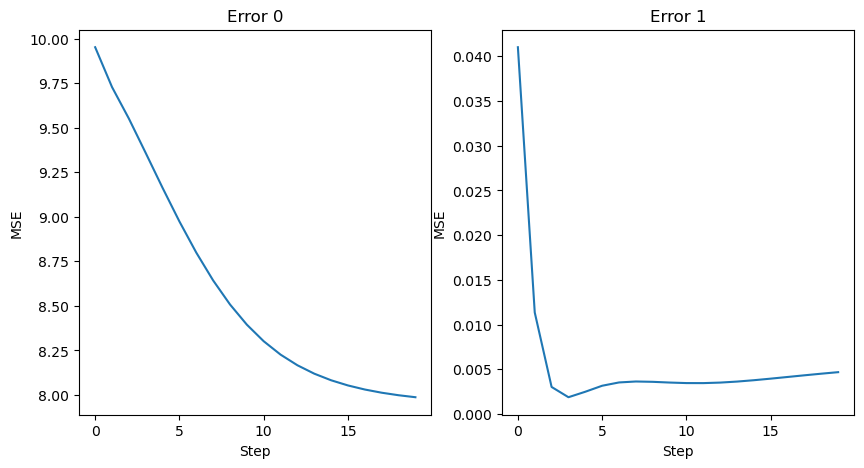

In [20]:
# plot errors over steps
import matplotlib.pyplot as plt
import numpy as np

all_es = []
idx = torch.randint(0, len(dataset), (1,))
x = dataset[idx][0].unsqueeze(0)
y = dataset[idx][1].unsqueeze(0)
R, E = model.init_vars(1)
for i in range(20):
    R, E = model.step(x, R, E)
    es = []
    for e in E:
        mse = e.square().mean().item()
        es.append(mse)
    all_es.append(es)

all_es = np.array(all_es)
all_es = all_es.T
all_es.shape

# plot errors using subplots
fig, axs = plt.subplots(1, len(all_es), figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.plot(all_es[i])
    ax.set_title(f"Error {i}")
    ax.set_xlabel("Step")
    ax.set_ylabel("MSE")



